# Expected Fantasy Points Part 1: Completion Probability Modeling

## Introduction

This noteboook is part 1 of my all encompasing expected fantasy points model. In it, I create a completion probability model using data from [nflscrapR](https://github.com/guga31bb/nflfastR-data) and selecting only features that are descriptive of a player's opportunity and excluding ones that would introduce a skill component into the model. For a summary of this completion probability modelling click [here](https://github.com/willmscaleb/Personal-Data-Projects/tree/main/NFL%20Expected%20Fantasy%20Points/Completion%20Probability%20Model) and of the overarching expected fantasy points project click [here](https://github.com/willmscaleb/Personal-Data-Projects/tree/main/NFL%20Expected%20Fantasy%20Points).

The code that follows will take you through a cleaned up version of my thought process from start to finish that includes data importing, function definitions, data preprocessing (cleaning, feature engineering, data exploration), initial modeling and hyperparameter tuning, model fitting and final scoring and processing the final output into expected fantasy points for both the passing attempts and receiving targets.

## Preprocessing and Exploration

### Packages & Data Importing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import xgboost as xgb
import time, gc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import train_test_split
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
import warnings
warnings.filterwarnings('ignore')

#data and script to read it taken from https://github.com/guga31bb/nflfastR-data.

#I used all data from 2009-2019 since 2009 was the first year with some metrics such as air-yards.
#At the end of this project, I will create a weekly automation script to read in 2020 data and 
#determine expected points from my models.
YEARS = [2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009]

data = pd.DataFrame()

for i in YEARS:  
    #low_memory=False eliminates a warning
    i_data = pd.read_csv('https://github.com/guga31bb/nflfastR-data/blob/master/data/' \
                         'play_by_play_' + str(i) + '.csv.gz?raw=True',
                         compression='gzip', low_memory=False)
    i_data['Year'] = str(i)
    i_data['Play_ID'] = i_data['play_id'].astype(str) + i_data['game_id'] 
    #sort=True eliminates a warning and alphabetically sorts columns
    data = data.append(i_data, sort=True)
    

#Filter for regular season data and reset index
data = data.loc[data.season_type == "REG"].reset_index(drop=True)

#Keep only relevant columns
cols = ['yardline_100', 'half_seconds_remaining', 'down', 'ydstogo', 'play_type', 'yards_gained', 'shotgun', 
        'no_huddle', 'qb_dropback', 'pass_location', 'air_yards', 'run_location', 'run_gap', 
        'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'posteam_score', 'defteam_score', 
        'score_differential', 'complete_pass', 'interception', 'fumble_lost', 'fumble','yards_after_catch',
        'touchdown','game_half','Play_ID','posteam_type','Year']
data = data[cols]

### Initial Function Definitions

In [2]:
#function to add percentages as text to plots specifically for binary variables
def plt_add_percentages(df,plot):
    sizes=[]
    total = len(df)
    for p in plot.patches:
        height = p.get_height()
        sizes.append(height)
        plot.text(p.get_x()+p.get_width()/2.,height + 2500,'{:1.2f}%'.format(height/total*100),
                  ha="center", fontsize=12) 
    plot.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights
    
#function for dropping collinear features based on a correlation coefficient threshold
#keeping the collinear feature that is most highly correlated to the target variable
def collin_filter(df,thresh,tgt):
    corr = df.corr()
    d = {"tgt_corr":abs(corr[tgt])}
    corrs = pd.DataFrame(data=d,index=corr[tgt].index)
    corrs = corrs.sort_values('tgt_corr',ascending=False)
    x = corrs.index
    for i in corrs.index:
        if i in corrs.index:
            vals = (abs(corr[i])).sort_values()
            cond1 = vals>=thresh
            cond2 = vals<1.0
            oth = vals[(cond1) & (cond2)].index
            for j in oth:
                if j in corrs.index:
                    corrs.drop(j,inplace=True)
                else:
                    continue
        else:
            continue
    return corrs

#function for log-loss scoring using true and predicted series
def score_ll(true, pred):
    return (true*np.log(pred) + (1-true)*np.log(1-pred)).mean()

#function for transforming selected variables with the yeo-johnson transform and
#showing these transformations before and after in terms of normal distributions
def yeo_j_plus_plots(df,var_list,subplot_dims,figsize,title,title_dims,padding):
    fig, ax = plt.subplots(subplot_dims[0],subplot_dims[1],figsize=figsize)
    fig.suptitle(title,y=title_dims[0], fontsize = title_dims[1])
    df1 = pd.DataFrame(index=df.index, columns=var_list)
    lmbdas = []
    count = -1
    for i in range(0,subplot_dims[0]):
        if i % 2 == 0:
            count+=1
            nt = df[var_list[count]]
            tr, lmbda = stats.yeojohnson(nt)
            for j in range(0,subplot_dims[1]):
                if j % 2 == 0:
                    sns.distplot(nt,fit=stats.norm,kde=False,norm_hist=False,ax=ax[i,j])
                    (mu, sigma) = stats.norm.fit(nt)
                    ax[i,j].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
                    ax[i,j].set_ylabel('Frequency')
                    t = var_list[count] + " Before Transformation"
                    ax[i,j].set_title(t)
                else:
                    stats.probplot(nt, plot=ax[i,j])

        else:
            for j in range(0,subplot_dims[1]):
                if j % 2 == 0:
                    sns.distplot(tr,fit=stats.norm,kde=False,norm_hist=False,ax=ax[i,j])
                    (mu, sigma) = stats.norm.fit(tr)
                    ax[i,j].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
                    ax[i,j].set_ylabel('Frequency')
                    t = var_list[count] + " After Transformation"
                    ax[i,j].set_title(t)
                else:
                    stats.probplot(tr, plot=ax[i,j])  
            df1.loc[:,var_list[count]] = tr
            lmbdas.append(lmbda)
    fig.tight_layout(pad=padding)
    plt.show()
    return df1, lmbdas

### 1st Iteration of Data Cleaning

In [3]:
#Filter for only plays with air_yards listed (i.e. pass plays)
rec = data.loc[data.air_yards.isnull() == False].reset_index(drop=True)

#drop irrelevant columns
rec.drop(['run_location','run_gap','play_type','qb_dropback'],axis=1,inplace=True)

#There are 73 pass plays with no pass location listed, so since this is a very small 
#portion of total entries we can just drop them from our dataset.
rec = rec.loc[rec.pass_location.isnull() == False].reset_index(drop=True)

#store the relevant receiving columns for use coming up.
cols_rec = rec.columns

#ignore defensive touchdowns
rec.iloc[rec.loc[rec.interception == 1].index,rec.columns.get_loc("touchdown")] = 0
rec.iloc[rec.loc[rec.fumble_lost == 1].index,rec.columns.get_loc("touchdown")] = 0

#If yac is N/A, assume it's 0
rec.yards_after_catch = rec.yards_after_catch.fillna(0)

#air_yards+YAC should be equal to yards_gained, so drop rows where this is not true
rec = rec.loc[((rec.yards_gained == rec.yards_after_catch + rec.air_yards) & 
              (rec.complete_pass == 1)) | (rec.complete_pass == 0)].reset_index(drop=True)

#Can't have a lost fumble and an incomplete pass, so drop these rows
ind = rec.loc[(rec.fumble_lost == 1) & (rec.complete_pass == 0)].index
rec = rec.drop(ind).reset_index(drop=True)

#Now I describe the dataset to get a better idea of it's contents.
#The dataset was so highly dimensional before this initial cleaning
#that a .describe output wouldn't have been very helpful until now
rec.describe()

,yardline_100,half_seconds_remaining,down,ydstogo,yards_gained,shotgun,no_huddle,air_yards,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,complete_pass,interception,fumble_lost,fumble,yards_after_catch,touchdown
count,194012.000000,194012.000000,194012.000000,194012.000000,194012.000000,194012.000000,194012.000000,194012.000000,194012.000000,194012.000000,194012.000000,194012.000000,194012.000000,194012.000000,194012.000000,194012.000000,194012.000000,194012.000000,194012.000000
mean,52.877374,808.854442,1.933262,8.938741,7.180319,0.715750,0.102942,8.402083,2.504861,2.569707,9.678752,12.624946,-2.946194,0.623611,0.025926,0.003814,0.007752,3.244217,0.044270
std,23.958049,547.358621,0.843111,3.983773,9.861511,0.451058,0.303884,10.102008,0.808968,0.699569,8.764689,10.707643,10.701496,0.484481,0.158916,0.061641,0.087704,6.189457,0.205696
min,1.000000,0.000000,1.000000,1.000000,-20.000000,0.000000,0.000000,-52.000000,0.000000,0.000000,0.000000,0.000000,-59.000000,0.000000,0.000000,0.000000,0.000000,-32.000000,0.000000
25%,35.000000,297.000000,1.000000,7.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,3.000000,3.000000,-9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,784.000000,2.000000,10.000000,5.000000,1.000000,0.000000,6.000000,3.000000,3.000000,7.000000,10.000000,-2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,73.000000,1280.000000,3.000000,10.000000,11.000000,1.000000,0.000000,13.000000,3.000000,3.000000,15.000000,20.000000,3.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000
max,99.000000,1800.000000,4.000000,50.000000,99.000000,1.000000,1.000000,65.000000,3.000000,3.000000,59.000000,62.000000,59.000000,1.000000,1.000000,1.000000,1.000000,91.000000,1.000000


### 1st Iteration of Feature Engineering

In [4]:
#shorten category names
rec.pass_location.replace({'left':'L','right':'R','middle':'M'},inplace=True)

#concatenate No huddle and shotgun into 1 feature and rename categories to make intuitive sense
rec['NoHud_Shotgun'] = rec.no_huddle.astype(str) + rec.shotgun.astype(str)
rec.NoHud_Shotgun.replace({'00': 'H_UC', '01': 'H_S', 
                           '10': 'NH_UC', '11': 'NH_S' },inplace=True)

#shorten category names
rec.game_half.replace({'Half1':'H1','Half2':'H2','Overtime':'OT'},inplace=True)

#Create 3rd feature adding game half to no huddle shotgun
rec['NoHud_Shotgun_Half'] = rec['NoHud_Shotgun'] + '_' + rec.game_half.astype(str)

#Teams act differently in overtime and there is a small sample size, so I just group overtime data points together
rec.NoHud_Shotgun_Half.replace({'H_S_OT':'OT','H_UC_OT':'OT','NH_S_OT':'OT',
                                'NH_UC_OT':'OT'},inplace=True)

#shorten category names
rec.posteam_type.replace({'home':'H','away':'A'},inplace=True)

#Create new feature binning distance to first down into 4 categories
rec['Dist'] = ''
rec.iloc[rec.loc[rec.ydstogo < 4].index,rec.columns.get_loc("Dist")] = 'S'
rec.iloc[rec.loc[(rec.ydstogo >= 4) & (rec.ydstogo < 7)].index,rec.columns.get_loc("Dist")] = 'M'
rec.iloc[rec.loc[(rec.ydstogo >= 7) & (rec.ydstogo <= 10)].index,rec.columns.get_loc("Dist")] = 'L'
rec.iloc[rec.loc[rec.ydstogo > 10].index,rec.columns.get_loc("Dist")] = 'VL'

#Make fewer groupings for 4th down due to small sample size
rec.iloc[rec.loc[(rec.ydstogo < 3) & (rec.down == 4.0)].index,rec.columns.get_loc("Dist")] = 'S'
rec.iloc[rec.loc[(rec.ydstogo >= 3) & (rec.ydstogo < 8) & (rec.down == 4.0)].index,rec.columns.get_loc("Dist")] = 'M'
rec.iloc[rec.loc[(rec.ydstogo >= 8) & (rec.down == 4.0)].index,rec.columns.get_loc("Dist")] = 'L'

#combine the newly binned distance with down
rec['Down&Dist'] = rec.Dist + rec.down.astype(str)
rec.iloc[rec.loc[rec.down == 1.0].index,rec.columns.get_loc("Down&Dist")] = '1'

#bin time remaining in half specifically in attempt to capture how teams act differently late in the half
rec['time_rem'] = ''
rec.iloc[rec.loc[rec.half_seconds_remaining < 16].index,rec.columns.get_loc("time_rem")] = '0-15s'
rec.iloc[rec.loc[(rec.half_seconds_remaining >= 16) & (rec.half_seconds_remaining < 31)].index,rec.columns.get_loc("time_rem")] = '16-30s'
rec.iloc[rec.loc[(rec.half_seconds_remaining >= 31) & (rec.half_seconds_remaining < 61)].index,rec.columns.get_loc("time_rem")] = '31-60s'
rec.iloc[rec.loc[(rec.half_seconds_remaining >= 61) & (rec.half_seconds_remaining < 121)].index,rec.columns.get_loc("time_rem")] = '1-2m'
rec.iloc[rec.loc[(rec.half_seconds_remaining >= 121) & (rec.half_seconds_remaining < 241)].index,rec.columns.get_loc("time_rem")] = '2-4m'
rec.iloc[rec.loc[rec.half_seconds_remaining >= 241].index,rec.columns.get_loc("time_rem")] = '4+m'

#bin score differential in attempt to capture how teams act differently in blow out games vs close games
rec['Score_Diff'] = ''
rec.iloc[rec.loc[(rec.score_differential < 17) & (rec.score_differential > -17)].index,rec.columns.get_loc("Score_Diff")] = '2Sc'
rec.iloc[rec.loc[(rec.score_differential < 9) & (rec.score_differential > -9)].index,rec.columns.get_loc("Score_Diff")] = '1Sc'
rec.iloc[rec.loc[(rec.score_differential < 4) & (rec.score_differential > -4)].index,rec.columns.get_loc("Score_Diff")] = 'FG'
rec.iloc[rec.loc[(rec.score_differential >= 17) | (rec.score_differential <= -17)].index,rec.columns.get_loc("Score_Diff")] = 'Blw'

#bin air-yards into 3 defined categories for deep, intermediate and short passes
rec['PassDepth'] = ''
rec.iloc[rec.loc[rec.air_yards < 8].index,rec.columns.get_loc("PassDepth")] = 'S'
rec.iloc[rec.loc[(rec.air_yards >= 8) & (rec.air_yards < 20)].index,rec.columns.get_loc("PassDepth")] = 'I'
rec.iloc[rec.loc[rec.air_yards >= 20].index,rec.columns.get_loc("PassDepth")] = 'D'

#combine binned pass depth with pass location (creates a 9 box 2d grid to define pass location)
rec["PassLocDp"] = rec.PassDepth + '_' + rec.pass_location

#split binned time remaining by half and replace rare occuring OT categories to one general OT
rec['TimeRemHalf'] = rec['time_rem'] + '_' + rec.game_half
rec.TimeRemHalf.replace({'4+m_OT':'OT','2-4m_OT':'OT','1-2m_OT':'OT','31-60s_OT':'OT',
                         '16-30s_OT':'OT','0-15s_OT' :'OT'},inplace=True)

### Exploratory Data Analysis

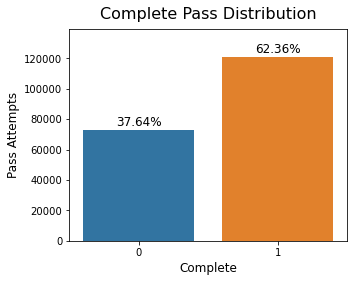

In [5]:
#Before starting plots, change the data types of certain features to numeric
intg = ['yardline_100','half_seconds_remaining','down','yards_gained','air_yards',
        'posteam_timeouts_remaining','defteam_timeouts_remaining','posteam_score',
        'defteam_score','score_differential','complete_pass','interception',
        'fumble_lost','fumble','yards_after_catch','touchdown']
for i in intg:
    rec[i] = rec[i].astype(int)

#plot the target variable distributions with percentages
plt.figure(figsize=(5,4))
tgt = sns.countplot(x="complete_pass",data=rec)
plt_add_percentages(rec,tgt)
tgt.set_title("Complete Pass Distribution", y=1.02, fontsize = 16)
tgt.set_xlabel("Complete", fontsize = 12)
tgt.set_ylabel("Pass Attempts", fontsize = 12)
plt.tight_layout(pad=1)
plt.savefig('cmp_dist.png')
plt.show()

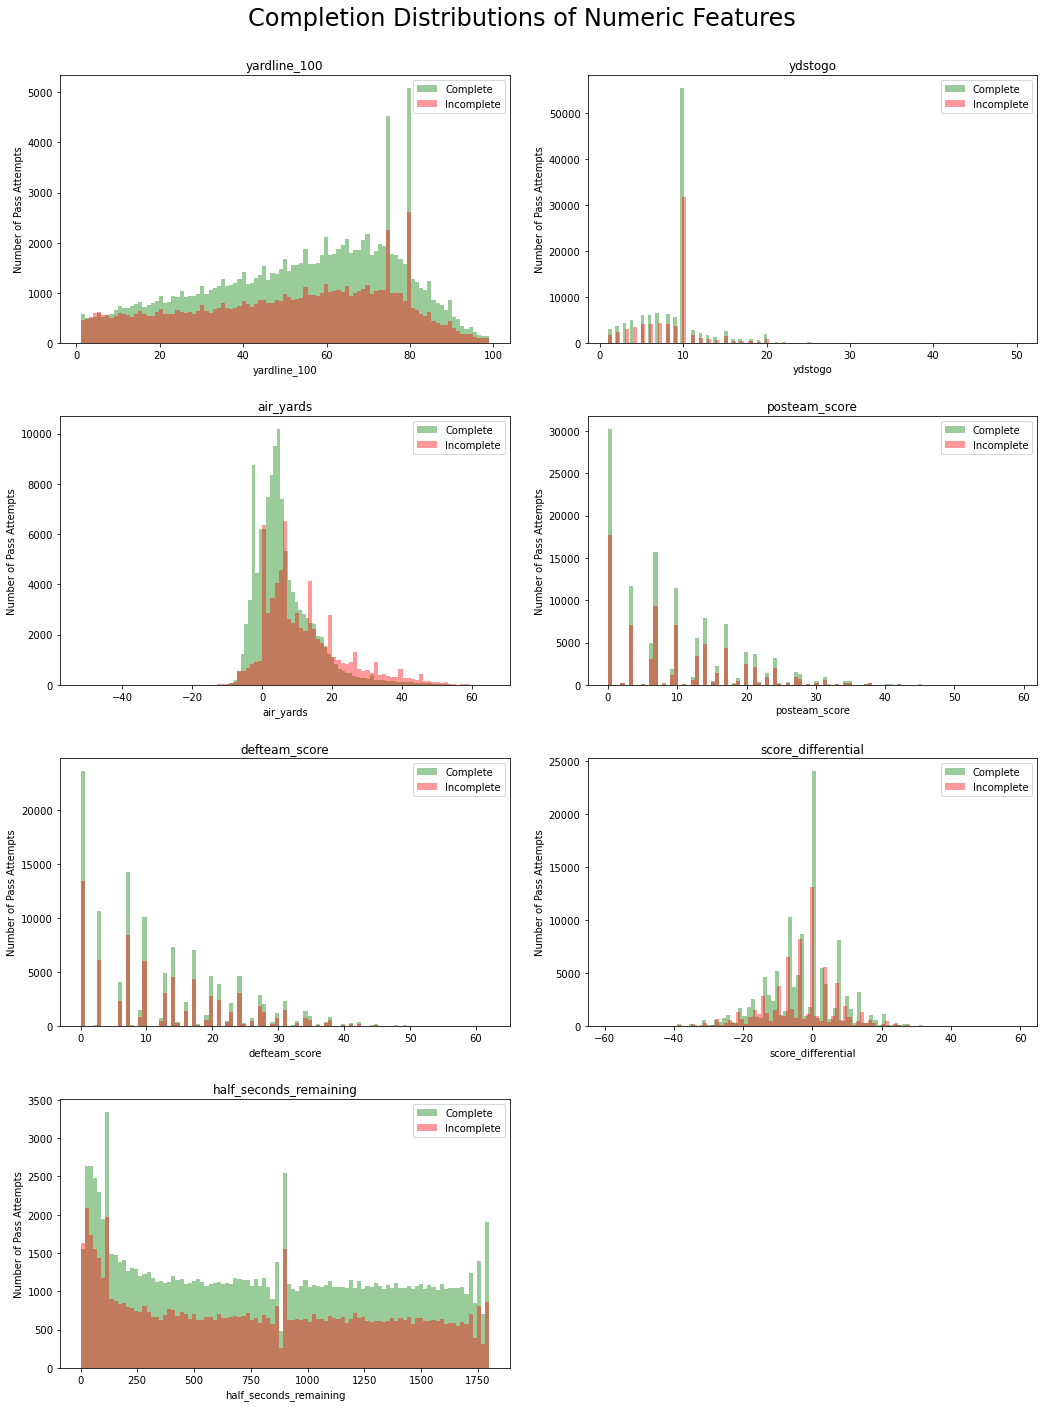

In [6]:
#store selected features to plot by numeric and categorical
cols_num = ['yardline_100', 'ydstogo', 'air_yards','posteam_score', 'defteam_score', 
            'score_differential','half_seconds_remaining']
cols_cat = ['pass_location','game_half','posteam_type','NoHud_Shotgun','Dist',
            'time_rem','Score_Diff','PassDepth','shotgun','no_huddle','down',
            'Year','NoHud_Shotgun_Half','Down&Dist','PassLocDp','TimeRemHalf']

#Plot histograms of for each numeric category showing both complete and incomplete distributions
fig, axes = plt.subplots(4, 2, figsize=(15,20))
fig.suptitle('Completion Distributions of Numeric Features',y=0.985, fontsize = 24)
count = 0
for i in range(0,4):
    for j in range(0,2):
        if count >= len(cols_num):
            break
        else:
            sns.distplot(rec.loc[rec.complete_pass == 1][cols_num[count]],bins=99,
                         kde=False,norm_hist=False,ax=axes[i,j],color="g")
            sns.distplot(rec.loc[rec.complete_pass == 0][cols_num[count]],bins=99,
                         kde=False,norm_hist=False,ax=axes[i,j],color="r")
            axes[i,j].legend(labels=['Complete','Incomplete'])
            axes[i,j].set_ylabel('Number of Pass Attempts')
            axes[i,j].set_title(cols_num[count])
            count+=1
axes[-1, -1].axis('off')
fig.tight_layout(pad=2.5)
plt.show()

#### Figure for Github Readme

In [7]:
#fig, axes = plt.subplots(1, 1, figsize=(7,4))
#sns.distplot(rec.loc[rec.complete_pass == 1]['air_yards'], #bins=50, 
#             kde=False, norm_hist=False, ax=axes, color="g")
#sns.distplot(rec.loc[rec.complete_pass == 0]['air_yards'], #bins=50, 
#             kde=False, norm_hist=False, ax=axes, color="r")
#axes.legend(labels=['Complete','Incomplete'])
#axes.set_ylabel('Pass Attempts')
#axes.set_title('Completion Distribution By Air Yards',y=1.05, fontsize = 16)
#fig.tight_layout(pad=1)
#plt.savefig('cmp_dist_ay.png')
#plt.show()

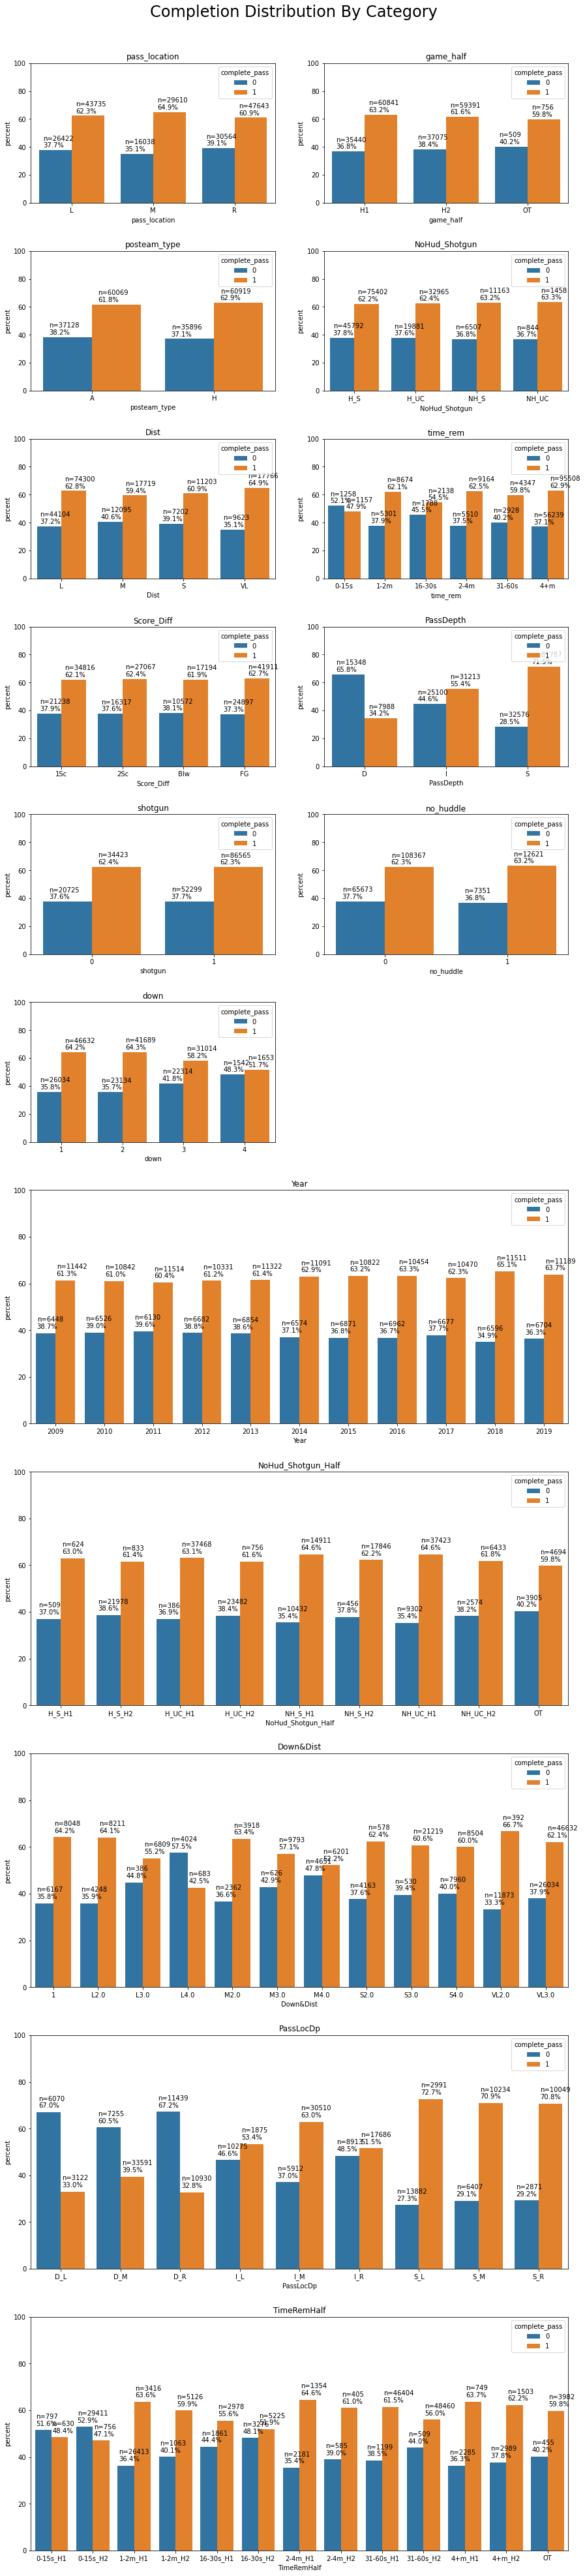

In [8]:
#plot all categorical variables based on their complete/incomplete distributions 
#by category with sample size and percentage distributions
fig = plt.figure(figsize=(13,55))
gs = fig.add_gridspec(27, 2)
fig.suptitle('Completion Distribution By Category',y=1.0, fontsize = 24)
y = 'complete_pass'
count = 0
for i in range(0,12,2):
    for j in range(0,2):
        if count == 11:
            break
        else:
            ax = fig.add_subplot(gs[i:i+2,j])
            x = cols_cat[count]
            df = rec.groupby(x)[y].value_counts()
            df = df.rename('Count').reset_index().sort_values(y).reset_index(drop=True)
            df1 = rec.groupby(x)[y].value_counts(normalize=True)
            df1 = df1.mul(100)
            df1 = df1.rename('percent').reset_index()
            sns.barplot(x=x,y='percent',hue=y,data=df1, ax=ax)
            ax.set_ylim(0,100)
            count2 = 0
            
            #Add a number of samples and a percentage for each complete and incomplete category
            for p in ax.patches:
                txt = str(p.get_height().round(1)) + '%'
                txt2 = 'n=' + str(df.Count[count2])
                txt_x = p.get_x() 
                txt_y = p.get_height()+2
                ax.text(txt_x+0.05,txt_y,txt,fontsize=10)
                ax.text(txt_x+0.05,txt_y+5,txt2,fontsize=10)
                count2+=1
            ax.set_title(x)
            #ax.set_ylabel('Number of Plays')
            count+=1

for i in range(12,27,3):
    ax = fig.add_subplot(gs[i:i+3,:])
    x = cols_cat[count]
    df = rec.groupby(x)[y].value_counts()
    df = df.rename('Count').reset_index().sort_values(y).reset_index(drop=True)
    df1 = rec.groupby(x)[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    sns.barplot(x=x,y='percent',hue=y,data=df1, ax=ax)
    ax.set_ylim(0,100)
    count2 = 0
    
    #Add a number of samples and a percentage for each complete and incomplete category
    for p in ax.patches:
        txt = str(p.get_height().round(1)) + '%'
        txt2 = 'n=' + str(df.Count[count2])
        txt_x = p.get_x() 
        txt_y = p.get_height()+2
        ax.text(txt_x+0.025,txt_y,txt,fontsize=10)
        ax.text(txt_x+0.025,txt_y+3,txt2,fontsize=10)
        count2+=1
    ax.set_title(x)
    #ax.set_ylabel('Number of Plays')
    count+=1
fig.tight_layout(pad=2.5)
plt.show()

#### Pass Location Grid Map

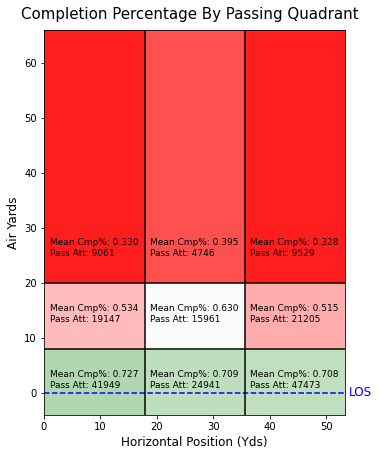

In [9]:
#Plot PassLocDp by splitting an NFL dimension field into the 9 location quadrants defined
#I also add a line of scrimmage line and only include typical air_yardage for field length.
#Finally I create a color scheme based on the mean completion rate 0.6236, lower being more red
#higher being more green
fig, ax = plt.subplots(1, 1, figsize=(5.4,7.0875))
fig.suptitle('Completion Percentage By Passing Quadrant',y=0.925, fontsize = 15)
ax.set_xlim(0,53.33)
ax.set_ylim(-4,66)
ax.set_ylabel('Air Yards', fontsize = 12)
ax.set_xlabel('Horizontal Position (Yds)', fontsize = 12)

#Add line of scrimmage
ax.text(54, -0.45, "LOS", fontsize=12, color='b')
plt.hlines(0,0,160, linestyles='dashed', color='b')

coord = [[0,17.8,-4,8],[17.8,35.53,-4,8],[35.53,53.33,-4,8],
         [0,17.8,8,20],[17.8,35.53,8,20],[35.53,53.33,8,20],
         [0,17.8,20,66],[17.8,35.53,20,66],[35.53,53.33,20,66]]
a = ['S_L','S_M','S_R','I_L','I_M','I_R','D_L','D_M','D_R']
for i in range(0,9):
    r = rec.loc[rec['PassLocDp'] == a[i]]['complete_pass']
    m = r.mean()
    l = len(r)
    
    #Set the mean to equal alpha 0 with quadrants getting less transparent the further they get from the mean
    alpha = 0.0 + 3*abs(m-0.6236)
    if m > 0.6236:
        color = 'green'
    else:
        color = 'red'
    
    #Add mean completion percentage and number of pass attempts for each grid and manually position them
    ax.fill_between([coord[i][0],coord[i][1]], coord[i][2], coord[i][3], facecolor=color, alpha=alpha)
    ax.text(coord[i][0]+1,coord[i][2]+7,"Mean Cmp%: {:.3f}".format(m),fontsize=9)
    ax.text(coord[i][0]+1,coord[i][2]+5,"Pass Att: {:.0f}".format(l),fontsize=9)

#split into appropriate grids
plt.hlines(8,0,160, color='k', alpha=1.0)
plt.hlines(20,0,160, color='k', alpha=1.0)
plt.vlines(17.8,-4,100, color='k', alpha=1.0)
plt.vlines(35.53,-4,100, color='k', alpha=1.0)
    
#Save figure for use in eda summary in Github Readme
plt.savefig('cmp_gridm.png')
plt.show()

### 2nd Iteration Feature Engineering and Data Cleaning

In [10]:
#for Years, I split into 2 categories: Before and after 2014 
#(when completion percentage appears to have improved).
#This was when the NFL began getting tougher on defensive holding,
#so it is quite plausible that this improved completion percentage
rec.Year.replace({'2019':1,'2018':1,'2017':1,'2016':1,'2015':1,'2014':1,
                  '2013':0,'2012':0,'2011':0,'2010':0,'2009':0},inplace=True)
rec.rename(columns={"Year":"after_2013"},inplace=True)
cols_cat[11] = "after_2013"

#I want to mean-encode all the categorical variables, as well as several numeric
#1st I combine all the variables for mean encoding into 1 list
cols_cat = cols_cat + ['yardline_100','ydstogo','air_yards','posteam_score',
                       'defteam_score','score_differential','half_seconds_remaining']

#mean encode categorical variables
#initialize array to store mean encoded variables for plotting after
mean_enc = ['']*len(cols_cat)
count = 0
for i in cols_cat:
    mean_enc[count] = i+'_mean'
    a = rec.groupby(i).agg({'complete_pass': ['mean']})
    a.columns = a.columns.droplevel(0)
    a.rename(columns={'mean':i+'_mean'},inplace=True)
    rec = pd.merge(rec,a,how="outer",on=i)
    count+=1


#Drop more variables that are either irrelevant to the model, 
#or would not be possible for the model to know in advance 
rec.drop(['fumble_lost','fumble','yards_gained','yards_after_catch','touchdown',
          'interception'],axis=1,inplace=True)

#Also dummy encode categoricals
cat = ['pass_location','game_half','posteam_type','NoHud_Shotgun','NoHud_Shotgun_Half',
       'Dist','Down&Dist','time_rem','Score_Diff','PassDepth','PassLocDp','TimeRemHalf']
rec = pd.get_dummies(rec, columns=cat)


### Plots of New Mean Encoded Features

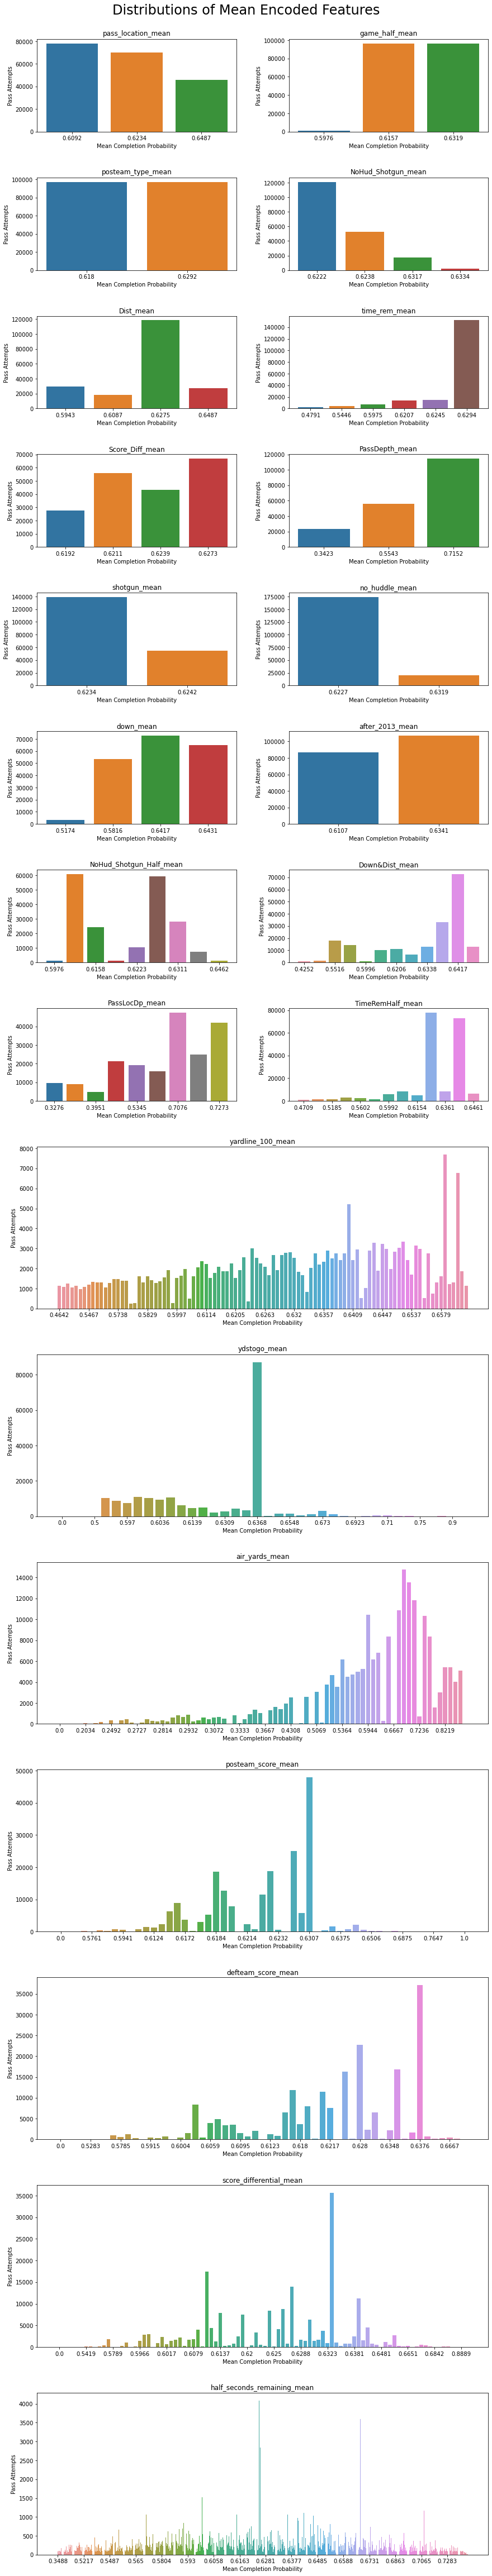

In [11]:
#Round to make the plots less cluttered
rounded = round(rec[mean_enc],4)

fig = plt.figure(figsize=(13,65))
gs = fig.add_gridspec(37, 2)
fig.suptitle('Distributions of Mean Encoded Features',y=0.99, fontsize = 24)

count = 0
for i in range(0,16,2):
    for j in range(0,2):
        ax = fig.add_subplot(gs[i:i+2,j])
        x = mean_enc[count]
        sns.countplot(x=x, data=rounded, ax=ax)
        ax.set_title(x)
        ax.set_xlabel('Mean Completion Probability')
        ax.set_ylabel('Pass Attempts')
        #set max number of xticks to 8 for readability
        ax.locator_params(axis='x', nbins=8)
        count+=1

#for mean_encoded variables with a wider range of values, make the plots larger for readability
for i in range(16,37,3):
    ax = fig.add_subplot(gs[i:i+3,:])
    x = mean_enc[count]
    sns.countplot(x=x, data=rounded, ax=ax)
    ax.set_title(x)
    ax.set_xlabel('Mean Completion Probability')
    ax.set_ylabel('Pass Attempts')
    ax.locator_params(axis='x', nbins=16)
    count+=1
fig.tight_layout(pad=3.5)
plt.show()

### Correlation Heat Maps

These visualizations are particularly important to explore for linear models as they show where and to what extent collinearities exist between features.

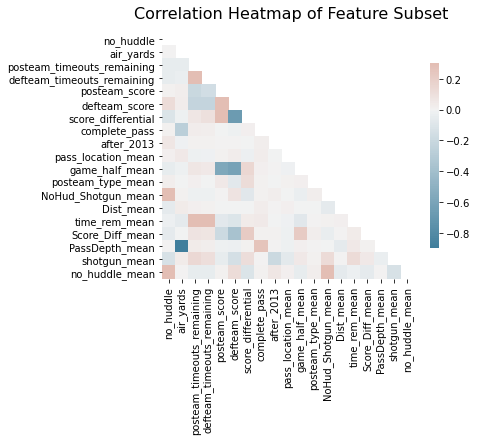

In [12]:
#To make the map readable, we only show a subset of the features.
corr = rec.iloc[:,5:25].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(6.8, 6.2))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, cbar_kws={"shrink": .75})
f.suptitle("Correlation Heatmap of Feature Subset", fontsize=16, x=0.6)
plt.tight_layout(pad=1.0)
plt.savefig('corr_hmap.png')
plt.show()

For any linear models, one of the pair of features corresponding to the darker blue boxes should be dropped to avoid collinearities. We will decide which of the pairs based on correlation coefficients to completed pas (the higher absolute value correlation coefficient stays, the lower one is dropped).

### Log-Loss Scoring & Generating A Baseline Score

Since we are attempting to predict completion probability (and not whether or not a pass is completed), it makes the most sense to optimize for log-loss rather than use a scoring metric such as ROC-AUC. Log-Loss is defined as: 

$$Logloss = -\frac{1}{N}\sum_{i=0}^N (y_iln(p_i)+(1-y_i)ln(1-p_i))$$

Like ROC-AUC, a simple useful baseline can be defined on which to compare the scores. For ROC-AUC, a value of 0.5 is the baseline, higher than 0.5 suggests an improvement over the baseline. To create a similar log-loss baseline, I made $p_i = p_{mean}$ or in other words, the mean completion percentage of the data sample. The logloss then becomes:

$$Logloss = -(p_{mean}ln(p_{mean})+(1-p_{mean})ln(1-p_{mean}))$$

This function is plotted below. Any log-loss in the green zone of this plot for its experiment specific mean probability suggests improved performance over the baseline.

Another, slightly more complex baseline that I use to compare final models to is using a univariate model where the variable is PassLocDepth where the probability predicted is simply the mean completion percentage for each category (i.e., the probability illustrated in the earlier 3x3 grid map plot). If the log-losses achieved by my models is less than the log-losses achieved by these baselines, it suggests my models are an improvement over the baseline.

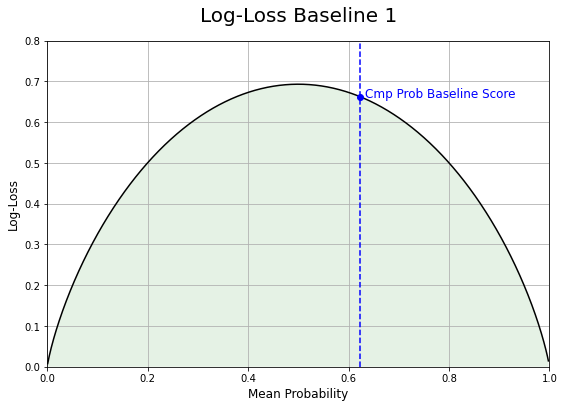

In [13]:
#define the log-loss function given constant probability
def ll(x):
    return -(x*np.log(x) + (1-x)*np.log(1-x))
x = np.arange(0.001, 0.999, 0.001)

#Plot the defined log-loss baseline with the green zone to illustrate where model 
#log-loss is expected/desired
fig, ax = plt.subplots(1, 1, figsize=(9,6))
ax.plot(x,ll(x),color='k')

#Uncomment the commented script to add a marker for the mean probability for this model
p = rec.complete_pass.mean()
ax.plot(p,ll(p),'o',color='b')
ax.text(p+0.01, 0.66, "Cmp Prob Baseline Score", fontsize=12, color='b')
plt.vlines(p,0,0.8, linestyles='dashed', color='b')

ax.fill_between(x, ll(x), 0, facecolor='green', alpha=0.1)
ax.set_title("Log-Loss Baseline 1", y=1.04, fontsize = 20)
ax.set_xlabel("Mean Probability", fontsize = 12)
ax.set_xlim(0,1.0)
ax.set_ylabel("Log-Loss", fontsize = 12)
ax.set_ylim(0,0.8)
ax.grid(True)
plt.savefig('logloss1.png')
plt.show()

## Modeling

### Linear Model Specific Processing

For linear models, I eliminate highly collinear features and attempt to transform any continuous/semi-continuous numeric features to a more normal distribution.

In [14]:
#set the correlation coefficient threshold to 0.7 and create a 
#linear model specific dataframe
rec_lin = rec[collin_filter(rec,0.7,'complete_pass').index]

#don't forget play_ids
rec_lin['Play_ID'] = rec['Play_ID']  

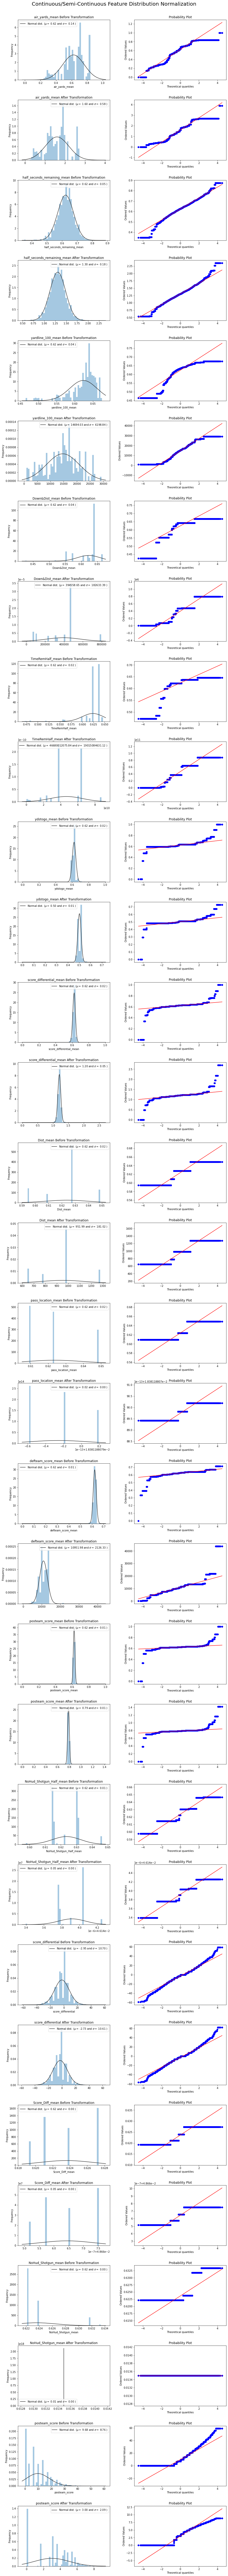

In [15]:
#yeo-johnson transform the following variables and plot them to 
#evaluate the success of normalization
x = ['air_yards_mean','half_seconds_remaining_mean','yardline_100_mean',
     'Down&Dist_mean','TimeRemHalf_mean','ydstogo_mean','score_differential_mean', 
     'Dist_mean','pass_location_mean','defteam_score_mean','posteam_score_mean',
     'NoHud_Shotgun_Half_mean', 'score_differential','Score_Diff_mean',
     'NoHud_Shotgun_mean','posteam_score']
subplot_dims = [32,2]
figsize = (13,140)
title = "Continuous/Semi-Continuous Feature Distribution Normalization"
title_dims = [0.9975,20]
padding= 3
df, lmbdas = yeo_j_plus_plots(rec_lin,x,subplot_dims,figsize,title,title_dims,padding)

#### Figure for Readme EDA Summary

In [16]:
#fig, ax = plt.subplots(2,2,figsize=(13,10))
#fig.suptitle('Yeo-Johsnon Transformation: yardline_100_mean',y=0.96, fontsize = 22)
#count = -1 
#for i in range(0,2):
#    if i % 2 == 0:
#        count+=1
#        nt = rec_lin['yardline_100_mean']
#        tr, lmbda = stats.yeojohnson(nt)
#        for j in range(0,2):
#            if j % 2 == 0:
#                sns.distplot(nt,fit=stats.norm,kde=False,norm_hist=False,ax=ax[i,j])
#                (mu, sigma) = stats.norm.fit(nt)
#                ax[i,j].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
#                ax[i,j].set_ylabel('Frequency')
#                t = 'yardline_100_mean' + " Before Transformation"
#                ax[i,j].set_title(t)
#            else:
#                stats.probplot(nt, plot=ax[i,j])
#    else:
#        for j in range(0,2):
#            if j % 2 == 0:
#                sns.distplot(tr,fit=stats.norm,kde=False,norm_hist=False,ax=ax[i,j])
#                (mu, sigma) = stats.norm.fit(tr)
#                ax[i,j].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
#                ax[i,j].set_ylabel('Frequency')
#                t = 'yardline_100_mean' + " Before Transformation"
#                ax[i,j].set_title(t)
#            else:
#                stats.probplot(tr, plot=ax[i,j])
#fig.tight_layout(pad=2.5)
#plt.savefig('yj_trnsf.png')
#plt.show()

Due to the semi-discrete/continuous nature of these variables and the fact that there are natural bunching locations in the data (i.e. ydstogo = 10, since that corresponds to a first down, cannot have plays over 99 yards since that is the length of the field, very rarely do players go backwards, times at the start and ends of quarters, halves, etcetera), it is not possible to transform all of them to a normal distribution effectively. Specifically, the tails of the distributions are very often not close to normal even after transformation and this will likely make certain algorithms (ones that assume normally distributed variables) less effective specifically when encountering thes tail of the distribution values. However, in general, the yeo-johnson transformation still makes these distributions more resemble a normal distribution, so it should still help the linear models I am trying.

In [17]:
rec_lin.loc[:,df.columns] = df.iloc[:,:]

In [18]:
#add the yeo-johnson transform results to the linear model specific dataframe
rec_lin.loc[:,df.columns] = df.iloc[:,:]

#It's time to split our dataset into a test and train set. 
#This one is specific for the linear models 
y = rec_lin['complete_pass']
X = rec_lin.drop(['complete_pass','Play_ID'],axis=1)

#store the ids 
ids = rec_lin.Play_ID

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Hyperparameter Tuning With Hyperopt

To tune the hyperparameters of the models, I prefer to use hyperopt, which uses Bayesian Optimization to tune models through probabilistic principles instead of the more computationaly expensive methods grid search or less effective randomized search. The Hyperopt package requires that an objective function be defined, which it finds hyperparameters to minimize this function. Below I have defined an objective function that matches the correct algorithm via the input parameters and uses 3 fold stratified cross validation scoring based on log-loss to tune the hyperparameters

In [19]:
def model_tune(params):
    #Time the tuning process
    time1 = time.time()
    
    #Select correct model Parameters to tune based on input params
    if 'C' in params:
        params = {"k" : int(params['k']),
                  'C': float(params['C'])
                 }
    elif 'l1_ratio' in params:
        params = {"k" : int(params['k']),
                  'alpha': float(params['alpha']),
                  'l1_ratio': float(params['l1_ratio']),
                  #'class_weight': params['class_weight']
                 }
    elif "n_neighbors" in params:
        params = {"k" : int(params['k']),
                  "n_neighbors" : int(params['k']),
                  "leaf_size" : int(params['leaf_size']),
                  #"p" : int(params['p']),
                  #'weights': params['weights'],
                  #'algorithm': params['algorithm']
                 }
    else:
        params = {'max_depth': int(params['max_depth']),
                  'gamma': "{:.3f}".format(params['gamma']),
                  'subsample': "{:.3f}".format(params['subsample']),
                  'reg_alpha': "{:.3f}".format(params['reg_alpha']),
                  'reg_lambda': "{:.3f}".format(params['reg_lambda']),
                  'learning_rate': "{:.3f}".format(params['learning_rate']),
                  'n_estimators': int(params['n_estimators']),
                  'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
                  'min_child_weight': '{:.3f}'.format(params['min_child_weight'])
                 }
    
    print("\n############## New Run ################")
    print(f"params = {params}")
    
    #3 Fold stratified k fold cross validation. Could do 5 fold, 
    #but would take longer and 3 fold is sufficient in this case
    FOLDS = 3
    count=1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
    y_oof = np.zeros(X_train.shape[0])
    score_mean = 0
    lmbdas = []
    for tr_idx, val_idx in skf.split(X_train, y_train):
        
        #Select the model of interest and add feature scaling and kbest feature selection where necessary
        if 'C' in params:
            clf = Pipeline(steps=[('Scaler', StandardScaler()),
                                  ('Feature_Selection', SelectKBest(f_classif,k = params['k'])),
                                  ('LR_Model', LogisticRegression(max_iter=1000,C = params['C']))])
        elif 'alpha' in params:
            clf = Pipeline(steps=[('Scaler', StandardScaler()),
                                  ('Feature_Selection', SelectKBest(f_classif,
                                                                    k = params['k'])),
                                  ('SGD_Model', SGDClassifier(loss='log', penalty='elasticnet',
                                                              max_iter=1000, alpha = params['alpha'],
                                                              l1_ratio = params['l1_ratio'],
                                                              #class_weight = params['class_weight']
                                                             ))])
        elif "n_neighbors" in params:
            clf = Pipeline(steps=[('Scaler', StandardScaler()),
                                  ('Feature_Selection', SelectKBest(f_classif,
                                                                    k = params['k'])),
                                  ('KNN_Model', KNeighborsClassifier(n_neighbors = params['n_neighbors'],
                                                                     leaf_size = params['leaf_size'],
                                                                     #p = params['p'],
                                                                     #weights = params['weights'],
                                                                     #algorithm = params['algorithm']
                                                                    ))])
        else:
            clf = Pipeline(steps=[('Scaler', StandardScaler()),
                                  ('XGB_Model', xgb.XGBClassifier(tree_method="hist", objective="binary:logistic",
                                                                  eval_metric="logloss", base_score=y_train.mean(), 
                                                                  **params
                                                                 ))])

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        #Fit and score for each cross validation split
        clf.fit(X_tr, y_tr)
        score = make_scorer(log_loss, needs_proba=True)(clf, X_vl, y_vl)
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    
    #Print model run time and log-loss average score (for each of the 3 cross validation folds)
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean Log-Loss: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return (score_mean / FOLDS)

### Logistic Regression

In [20]:
#Set parameter space of interest
#param_space = {"k" : hp.quniform('k', 35, 75, 1),
#               "C" : hp.uniform('C', 0.1, 0.45)
#              }

#set a reasonable max_evals so that the tuning doesn't take too long
#best = fmin(fn=model_tune, space=param_space, algo=tpe.suggest, max_evals=50)

#best_params = space_eval(param_space, best)

In [21]:
#the best found parameters
#print("BEST PARAMS: ", best_params)

### Stochastic Gradient Descent

In [22]:
#param_space = {"k" : hp.quniform('k', 25, 50, 1),
#               "alpha" : hp.uniform('alpha', 0.0005, 0.01),
#               "l1_ratio" : hp.uniform('l1_ratio', 0.0, 0.25),
               #"class_weight" : hp.choice("class_weight", [None,'balanced']),
#              }

#best = fmin(fn=model_tune, space=param_space, algo=tpe.suggest, max_evals=100)

#best_params = space_eval(param_space, best)

In [23]:
#print("BEST PARAMS: ", best_params)

### K-Nearest Neighbors (NOTE: Performs Poorly And Is Very Slow)

KNN is a non-parametric algorithm, so data is not assumed to be normally distributed. This should theoretically be beneficial for the model as, even after the transformations, many of the semi-continuous features are still not normally distributed.

For KNN, collinear variables are not necessarily problematic, but high dimensionality is. So, at first I will try training a KNN model similarly to our linear models with the same unique linear model dataset used for them. Then I will try using the full dataset (with collinear variables) with and without PCA for feature selection to lower dimensionality...

**NOTE:** the KNN model tuning was taking a very long time and performing poorly, so I just proceeded with the best parameters I found up to date and stopped pursuing optimization of the KNN model since it didn't seem promising anyway

In [24]:
#param_space = {"k" : hp.quniform('k', 35, 55, 1),
#               "n_neighbors" : hp.quniform('n_neighbors', 35, 55, 1),
#               "leaf_size" : hp.quniform('leaf_size', 20, 45, 1),
               #"p" : hp.quniform('p', 1, 4, 1),
               #"weights" : hp.choice("weights", ['uniform','distance']),
               #"algorithm" : hp.choice("algorithm", ['ball_tree','kd_tree']),
#              }

#best = fmin(fn=model_tune, space=param_space, algo=tpe.suggest, max_evals=4)

#best_params = space_eval(param_space, best)

In [25]:
#print("BEST PARAMS: ", best_params)

### XGBoost

For XGBoost, collinearities and non-normally distributed continuous variables are not important at all (keep in mind that certain loss functions require normality like mean-squared error, so just because the xgboost algorithm doesn't require normality, the objective and scoring used could require it), so I use the original, non-linear model specific dataframe.

In [26]:
#Split the original dataframe using the same random seed so that 
#the rows are identical to the previously tuned models
y = rec['complete_pass']
X = rec.drop(['complete_pass','Play_ID'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
#Define the param space of interest (originally, I used a wider 
#param space with higher max_evals, but after running it a few times, 
#I narrowed each)
#param_space = {"n_estimators" : hp.quniform('n_estimators', 100, 300, 1),
#               "learning_rate" : hp.uniform('learning_rate', 0.001, 0.25),
#               "max_depth" : hp.quniform('max_depth', 3, 9, 1),
#               "gamma" : hp.uniform('gamma', 0.0, 1.5),
#               "min_child_weight" : hp.uniform('min_child_weight', 1.0, 4.0),
#               #For extremely unbalanced data:
#               #"max_delta_step" : hp.choice('max_delta_step', list(range(0, 10, 1))),
#               "subsample" : hp.uniform('subsample', 0.4, 0.9),
#               "colsample_bytree" : hp.uniform('colsample_bytree', 0.5, 1.0),
#               "reg_alpha" : hp.uniform('reg_alpha', 0.0, 1.5),
#               "reg_lambda" : hp.uniform('reg_lambda', 0.0, 1.5),
#              }

# Set algoritm parameters
#best = fmin(fn=model_tune, space=param_space, algo=tpe.suggest, max_evals=25)

# Print best parameters
#best_params = space_eval(param_space, best)

In [28]:
#the best XGBoost parameters found
#print("BEST PARAMS: ", best_params)

### Model Results

From our cross-validation hyper-parameter tuning, we can see that our XGBoost model performs the best. It is only slightly better than our logistics regresseion and stochastic gradient descent models though, and is much more computationally expensive. The KNN model performed the worst by far and was the most computationally expensive. For our purposes, the XGBoost model is fast enough to be reasonable and since model intepretability is not of vital importance for us, we will select the XGBoost model.

Just for fun, let's train each of our models on the 80% train dataset and evaluate it's performance on the test set. We can also test combining the predictions of the different models with various weighting (weight the xgb model more since it was the most effective)

In [29]:
#Store the train and test sets for XGBoost. 
#The results (y) are the same for XGBoost as the other models since the same random seed was used.
Xgb_train = X_train
Xgb_test = X_test

#Reset the train and test sets for the other models
y = rec_lin['complete_pass']
X = rec_lin.drop(['complete_pass','Play_ID'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Use the best parameters found through the cross validated Bayesian optimization
xgb_model = Pipeline(steps=[('Scaler', StandardScaler()),
                            ('XGB_Model', xgb.XGBClassifier(tree_method="hist", objective="binary:logistic",
                                                            eval_metric="logloss", base_score=y_train.mean(),
                                                            colsample_bytree=0.8638551306622482, 
                                                            gamma=0.060790367842704196, 
                                                            learning_rate=0.02041950391229818, max_depth=6,
                                                            min_child_weight=2.3572909643216926, n_estimators=174,
                                                            reg_alpha=0.38323756782787083,
                                                            reg_lambda=1.3098430448987843, 
                                                            subsample=0.5030734591625123
                                                           ))])

knn_model = Pipeline(steps=[('Scaler', StandardScaler()),
                            ('Feature_Selection', SelectKBest(f_classif, k=43)),
                            ('KNN_Model', KNeighborsClassifier(n_neighbors=42,
                                                               leaf_size=22
                                                              ))])

sgd_model = Pipeline(steps=[('Scaler', StandardScaler()),
                            ('Feature_Selection', SelectKBest(f_classif, k = 50)),
                            ('SGD_Model', SGDClassifier(loss='log', penalty='elasticnet',
                                                        max_iter=1000, alpha=0.009895942785561985,
                                                        l1_ratio=0.04829400907821461
                                                       ))])

logr_model = Pipeline(steps=[('Scaler', StandardScaler()),
                             ('Feature_Selection', SelectKBest(f_classif, k=73)),
                             ('LR_Model', LogisticRegression(max_iter=1000, C=0.44713609936766063))])


models = [xgb_model, knn_model, sgd_model, logr_model]
x = ['true_cmp', 'xgb_cmp_prob', 'knn_cmp_prob','sgd_cmp_prob', 'logr_cmp_prob']

#Setup a predictions dataframe to store predictions from each model
preds = pd.DataFrame(index=X_test.index, columns=x)
preds['true_cmp'] = y_test

count = 1
for i in range(0,4):
    #For xgboost model, make sure to use the xgb specific training and test set
    #Fit the models and store the probability prediction in the preds dataframe
    if count == 1:
        models[i].fit(Xgb_train, y_train)
        preds[x[count]] = models[i].predict_proba(Xgb_test)[:,1]
        count+=1
    else:
        models[i].fit(X_train, y_train)
        preds[x[count]] = models[i].predict_proba(X_test)[:,1]
        count+=1

#try a few model combinations
preds['equal_weight_prob'] = (preds.logr_cmp_prob+preds.knn_cmp_prob+preds.xgb_cmp_prob+
                              preds.sgd_cmp_prob)/4
preds['unequal_weight_prob'] = (0.5*preds.logr_cmp_prob+0.1*preds.knn_cmp_prob+
                                0.2*preds.xgb_cmp_prob+0.2*preds.sgd_cmp_prob)
preds['no_knn_unequal_weight'] = (0.5*preds.logr_cmp_prob+0.25*preds.xgb_cmp_prob+
                                  0.25*preds.sgd_cmp_prob)

#create baseline models. 
#one for simply the mean and one using just the mean encoded PassLocDp (as plotted earlier).
preds['baseline_mean'] = y_train.mean()
preds['baseline_passlocdp'] = Xgb_test.PassLocDp_mean

In [30]:
#Create a dataframe for the log-loss scores of each model
x = preds.columns
d = []
for i in range(1,len(x)):
    d.append({'Model':x[i], 'Log-Loss Score':score_ll(preds.true_cmp, preds[x[i]])})
best_models = pd.DataFrame(data=d).sort_values('Log-Loss Score',ascending=False).reset_index(drop=True)
best_models

,Model,Log-Loss Score
0,xgb_cmp_prob,-0.601049
1,no_knn_unequal_weight,-0.604318
2,unequal_weight_prob,-0.604797
3,equal_weight_prob,-0.605397
4,logr_cmp_prob,-0.606708
5,sgd_cmp_prob,-0.607473
6,knn_cmp_prob,-0.624625
7,baseline_passlocdp,-0.627003
8,baseline_mean,-0.662986


In [31]:
#Create an Expected fantasy points dataframe to store expected points totals for each play with play_ids.
#Play_ids are necessary so results can be properly merged with results from other parts of this project
x_merged = pd.concat([Xgb_train, Xgb_test]).sort_index()
y_merged = pd.concat([y_train, y_test]).sort_index()
exp_fpts = pd.DataFrame(index=ids.index,columns=['Play_ID','exp_rec','exp_rec_hppr_pts',
                                                 'exp_recyds_pts','exp_passyds_pts'])
models[0].fit(x_merged, y_merged)
exp_fpts['Play_ID'] = ids
exp_fpts['exp_rec'] = models[0].predict_proba(x_merged)[:,1]
exp_fpts['exp_rec_hppr_pts'] = 0.5*exp_fpts['exp_rec']
exp_fpts['exp_recyds_pts'] = rec.air_yards*0.1
exp_fpts['exp_passyds_pts'] = rec.air_yards*0.04

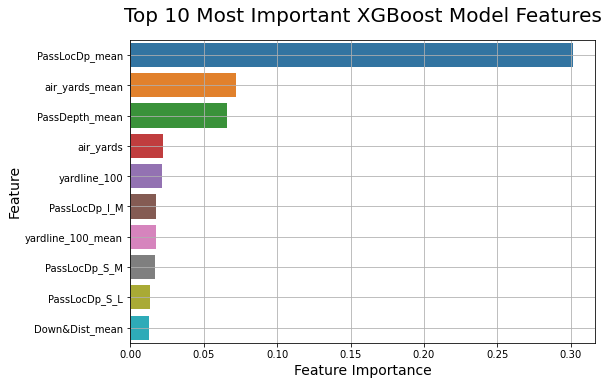

In [32]:
#create mini dataframe for feature importances to be used in the top 10 plot
feat_imp = pd.DataFrame()
feat_imp['Feature']= Xgb_train.columns
feat_imp['Feature Importance'] = models[0]['XGB_Model'].feature_importances_
feat_imp.sort_values(by='Feature Importance',ascending=False,inplace=True)

#Top 10 most important XGBoost features for the model
plt.figure(figsize=(9,6))
f = sns.barplot(x="Feature Importance", y="Feature", data=feat_imp[:10])
f.set_title("Top 10 Most Important XGBoost Model Features", y=1.04, fontsize = 20)
f.set_xlabel("Feature Importance", fontsize = 14)
f.set_ylabel("Feature", fontsize = 14)
f.grid(True)
plt.tight_layout(pad=3.0)
plt.savefig('xgb_f_imp.png')
plt.show()

In [33]:
exp_fpts.head()

,Play_ID,exp_rec,exp_rec_hppr_pts,exp_recyds_pts,exp_passyds_pts
0,1852019_01_ATL_MIN,0.712077,0.356039,0.1,0.04
1,2442012_14_NO_NYG,0.691072,0.345536,0.1,0.04
2,1902017_06_PHI_CAR,0.724023,0.362012,0.1,0.04
3,1672014_13_ARI_ATL,0.424897,0.212449,0.1,0.04
4,1472019_09_NE_BAL,0.725144,0.362572,-0.4,-0.16
